# WSN-Localization
Localization algorithms are used to locate the source of a signal, based on the characteristics of the signal when it is received at different locations. The process involves transmitting a signal from a device at an unknown location (called the “target” node) and recording signal characteristics at receiver nodes at known locations, also called “anchor” nodes. Some applications include locating the center of the rotor core in hearts with Atrial Fibrillation (AFib), which allows for treatment, and locating the source of a forest fire. Several localization techniques exist, such as Time of Arrival (TOA), Time Difference of Arrival (TDOA), and Modified Time Difference of Arrival (mTDOA). It has been shown that mTDOA is particularly useful in the case of AFib modeled by the FitzHugh-Nagumo (FN) model since it gives the signal propagation speed as an output rather than an input. In mTDOA, using the locations of the anchor nodes and the relative times of reception of the signal by the anchor nodes, the location of the target node, the propagation speed, and other auxiliary information are estimated. 

This project aims to improve this algorithm by considering the entire received signal, rather than only the initial reception time, and applying synchronization-based techniques to estimate time delays. In synchronization, the influence delay between two signals can be deduced using the mutual information (MI) between time-shifted versions of those signals. When the MI is at a maximum, it is likely that the particular time delay that yields the maximum MI is the correct estimate of the delay between the transmitted and received signal. Outputs from the FN model at the locations of the anchor nodes can be put under this MI Time Shift process to learn the time difference between two anchor nodes, which can be fed to the standard mTDOA algorithm. 

## The Theory
There are two major kinds of signal localization, localization involving a single transmitted “message” or signal, and that involving a continuous signal received over time. Both use many “anchor nodes”, which receive the signal and one or more target nodes which transmit the signal.

### Single Message
With the single message system, it is easy to determine the time delay of the received signal between two anchor nodes; the received time at one node can be subtracted from the received time at another node. These time delays, denoted $t_{jk}$ for the time difference between the $j$ th and $k$ th nodes, can be fed into matrices which can produce an estimate for the location of the target node. In each localization method, there are three matrices/vectors, coming together into the equation, $\textbf{Hx}=\textbf{b}$. $\textbf{x}$ contains the location the target node and sometimes other helpful information, such as the time of transmission or the speed of propagation. $\textbf{H}$ and $\textbf{b}$ contain the gathered information from the time delays. $r_j$ is the position of the $j$ th node (with 0 being target), $t_j$ is the absolute time of arrival of the message at the $j$ th node, and $c$ is the propagation speed. These are the matrices for mTDOA. 

$
\textbf{H}=\
\begin{bmatrix}\
2(\textbf{r}_2 - \textbf{r}_1) & -2(t_2-t_1) & (t_2^2-t_1^2)\\\
2(\textbf{r}_3 - \textbf{r}_1) & -2(t_3-t_1) & (t_3^2-t_1^2)\\\
2(\textbf{r}_4 - \textbf{r}_1) & -2(t_4-t_1) & (t_4^2-t_1^2)\\\
\vdots\\\
2(\textbf{r}_n - \textbf{r}_1) & -2(t_n-t_1) & (t_n^2-t_1^2)\
\end{bmatrix}\
\\\
\\\
b=\
\begin{bmatrix}\
||\textbf{r}_2||^2 - ||\textbf{r}_1||^2\\\
||\textbf{r}_3||^2 - ||\textbf{r}_1||^2\\\
||\textbf{r}_4||^2 - ||\textbf{r}_1||^2\\\
\vdots\\\
||\textbf{r}_N||^2 - ||\textbf{r}_1||^2\
\end{bmatrix}\
\\\
\\\
\textbf{x}=\
\begin{bmatrix}\
\textbf{r}_0\\\
c^2 t_0\\\
c^2\
\end{bmatrix}\
$

The code supports TOA, TDOA, mTDOA, and cTDOA. 

If the system includes multiple target nodes, an iterative approach may be needed to localize all of them, even transmitting from the same target node twice. 

### Continuous Signal
In many cases, the received signal is not one event but a continuous, time-varying signal. The time delay between two signals can be determined using the Mutual Information (MI) Time Shift method mentioned in the introduction. For each time shift, the MI between the two signals is calculated, and the time shift that yields the highest MI is said to be the time delay between the two received signals. Once the time delays between the received signals at each node and the received signal at node 1 (the “base” anchor) are calculated, the time delays can be fed into whichever algorithm is needed. Typically, mTDOA or cTDOA will be used for this because they do not require the propagation speed. 

The code supports a few signal types including Gaussian Auto-Regressive (`"ar"`) and FitzHugh-Nagumo (`"fn"`). 

## The Code

In [17]:
from WSN import *
from matplotlib import pyplot as plt
np.random.seed(1234)

### Initializing a WSN
The localization algorithms are implemented in the `WSN` class (`WSN.py`). To run the algorithms, a `WSN` can be created and worked with directly, or an `App` (`App.py`) can be created which creates a `WSN` for itself. Assuming, a `WSN` is being used directly, it accepts the parameters: `N`, the number of nodes (anchors + targets); and `size`, the width of the location space. The location space is always square, $[0, size)^2$. 100 is typically used for `size`. 

`WSN` also accepts a parameter for the standard deviation of the noise added to time measurements. Noise is on by default, so pass `std=0` to disable it.

In [18]:
wsn = WSN(size=100, N=6, std=0)

### Creating the nodes
Then, the nodes must be created by calling either `reset_nodes` or `reset_clusters`. `reset_nodes` randomizes `N` node positions and stores them in `self.nodes`. If cTDOA is being used, `reset_clusters` should be called instead so that the nodes are initialized in clusters; and `num_clusters` and `cluster_size` should either be set by passing key word arguments to `WSN`’s initializer or setting them before calling `reset_clusters`. `reset_clusters` chooses `num_clusters` random positions around the location space and then places `cluster_size` nodes around each cluster. It also resets `self.N` to `num_clusters` * `cluster_size`. 

Alternatively, the nodes can be set manually be assigning the `WSN`’s variable, `nodes`, with a numpy array of shape `(N, 2)`. 

In [19]:
wsn.reset_nodes()

6


### Selecting anchor nodes
After the nodes are created, the anchor nodes should be selected by passing a set of indices to `reset_anchors`. One can select the first `n` nodes to be anchor nodes by calling `reset_anchors(range(n))`. If cTDOA is being used, then all nodes should be anchor nodes. (The estimated position of the target node should be the center of the rotor core in the FN model.)


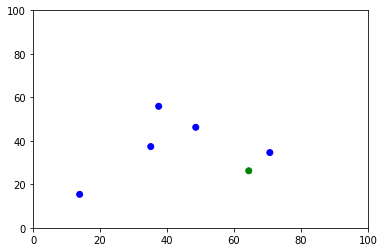

In [20]:
# Let node 0 be the target node
wsn.reset_anchors(range(1, 6))

plt.scatter(wsn.nodes[:, 0], wsn.nodes[:, 1], \
    c=["blue" if i in wsn.anchor_nodes else "green" for i in range(6)])
plt.xlim((0, 100))
plt.ylim((0, 100))
plt.show()

### Estimating target position
Finally, the localization can be done using `localize` for single-message localization or `localize_continuous` for continuous-signal localization. 

`localize` receives an argument, `method`, a string describing which method to use (`"TOA"`, `"TDOA"`, etc.). First, it generates the time delays using `transmit`, which returns a list of tuples containing the positions, received times, and other information from each node and passes those results to `get_H_and_b` for whichever method is being used, and calculates the estimated position of the target node. 

`localize_continuous` receives two arguments, `method` and `signal_type`. `signal_type` is a string containing which signal should be used in the simulation (`"ar"` or `"fn"`). It uses `transmit_continuous`, which returns a list of tuples containing the positions and received signals (as a numpy array) at each node. Then it uses `get_time_delay` (from `mutual_information.py`) to find the time delay between the signal at each anchor and the base anchor. It reformats the results from `localize_continuous` to look like the results from `localize` and passes them to `get_H_and_b` like normal.  

The return value from these `localize` and `localize_continuous` is an ndarray that contains the estimated positions of *all* nodes, not just the targets, unless `signal_type == 'fn'`, in which case the return value is a 1x2 array containing the position of the target node. The target node is determined by the FN solution, not a node in `wsn.nodes`.


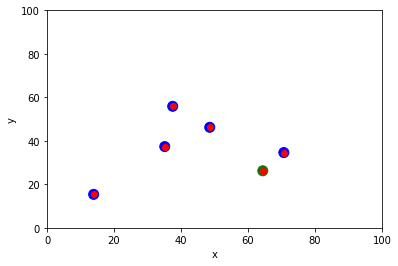

In [21]:
est_pos = wsn.localize("mTDOA")

plt.scatter(wsn.nodes[:, 0], wsn.nodes[:, 1], \
    c=["blue" if i in wsn.anchor_nodes else "green" for i in range(6)], s=100)
plt.scatter(est_pos[:, 0], est_pos[:, 1], c="red")
plt.xlim((0, 100))
plt.ylim((0, 100))
plt.xlabel("x")
plt.ylabel("y")
plt.show()


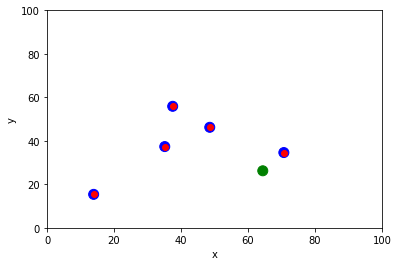

In [22]:
# Add some noise
wsn.std = 0.01
est_pos = wsn.localize("mTDOA")

plt.scatter(wsn.nodes[:, 0], wsn.nodes[:, 1], \
    c=["blue" if i in wsn.anchor_nodes else "green" for i in range(6)], s=100)
plt.scatter(est_pos[:, 0], est_pos[:, 1], c="red")
plt.xlim((0, 100))
plt.ylim((0, 100))
plt.xlabel("x")
plt.ylabel("y")
plt.show()


The FitzHugh-Nagumo (FN) model is one type of signal which works well with TDOA. It is described by this system of partial differential equations and can be applied to 0+ dimensions. Here, the 2D version is used. $v$ and $w$ are the outputs, and $ε$, $I_p$, $D$, $β$, $γ$, $w_h$, and $w_l$ are parameters of the model. $I_p$ represents the added stimulus which creates the waves, but it only applies to certain locations at certain times. With this version of the model, waves only came when the start time of $I_p$ was greater than 0 (~2 seconds). 

$
\frac{\partial v}{\partial t} = \frac{1}{\epsilon}\
\left(v - \frac{v^3}{3}- w \right) + \
I_p + D\left(\frac{\partial ^2 v}{\partial x^2} + \frac{\partial ^2 v}{\partial y^2}\right)\
\\\
\\\
\frac{\partial w}{\partial t} = \
\epsilon (v + \beta - \gamma w)\
\left(\frac{w_h-w_l}{1+e^{-4v} } + w_l\right)\
$

The solution to the FN model was approximated using `py-pde` (which uses the Finite Difference Method). The model itself is found in `fn.py`, and the parameters for generating the default FN solution are in `mutual_information.py` under `default_fn_equ_params`. The parameters for the shown solution are as follows: `{"N": 128, "T": 1000, "dt": 0.1, "D": 1.0, "a": 0.5, "b": 0.7, "c": 0.3, "I0": 1.0, "stim": [[[25, 40], [59, 69], [59, 69]]]}`. Note that `I0` represents the magnitude of of $I_p$, and `stim` specifies the location and duration of the stimulus (Frames 25-40, xrange 59-69, yrange 59-69). Some of the variables used in the code go by different names than in the FN equations. `a`, `b`, and `c` in the code correspond to $γ$, $β$, and $1/ε$, respectively. 

<image src="README_files/fn1.png" width="1000px"></image>

The shown solution is the final frame of a solution to the equation with the above parameters with the horizontal axis representing $x$, the vertical axis representing $y$, the left graph for $v$, and the right graph for $w$. To find the solution with the default parameters, call `solve_default_fn_equ` from `mutual_information.py` and read from `default_fn_sol` which is a numpy array of shape `(T, 2, N, N)` containing the states of $v$ and $w$ for each of `T` frames. Be sure to `import mutual_information as mtin` and read from `mtin.default_fn_sol`. If you do `from mutual_information import *`, then `default_fn_sol` will not get written to by `solve_default_fn_equ`. 


In [23]:
import mutual_information as mtin

mtin.solve_default_fn_equ(resolve=False)

Note: The default parameters are stored in `mtin.default_fn_equ_params` and can be changed, but after changing them, `mtin.default_fn_equ` should be reinstantiated to fit the new parameters.

```Python
mtin.default_fn_equ_params["dt"] = 0.01
mtin.default_fn_equ_params["T"] = 20_000
mtin.default_fn_equ_params["stim"] = [[[250, 350], [45, 65], [45, 65]]]
mtin.default_fn_equ = FHN(**mtin.default_fn_equ_params)
```

Examples of that the solutions look like can be found in the folder, `fn_videos`. Each video is in a subdirectory which also contains the parameters used to generate that video.

The signals are "generated" by pulling the value of the FN solution at the position of the node. Technically, $v$ and $w$ are both outputs of the FN model, but they are both periodic with the same period, so only $v$ is used. 

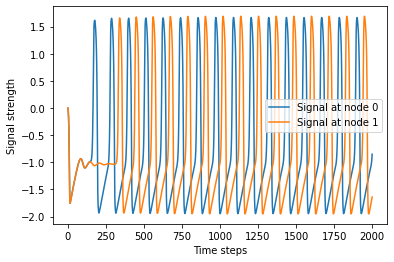

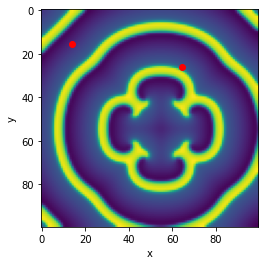

In [27]:
sigs = np.array([
    mtin.default_fn_sol[:, 0, int(node[1]), int(node[0])]
    for node in wsn.nodes
])
plt.plot(sigs[0], label="Signal at node 0")
plt.plot(sigs[1], label="Signal at node 1")
plt.legend()
plt.xlabel("Time steps")
plt.ylabel("Signal strength")
plt.show()

plt.imshow(mtin.default_fn_sol[-1, 0])
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(wsn.nodes[:2, 0], wsn.nodes[:2, 1], c="red")
plt.show()